In [175]:
! pip install pandas geopandas numpy matplotlib descartes pygeos

In [176]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [177]:
%matplotlib inline

In [178]:
plt.rcParams['figure.figsize'] = (20, 10)

In [1]:
madrid = gpd.read_file('data/districts.geojson').dropna().to_crs("crs")
madrid.rename(columns={'name': 'district'}, inplace=True)
madrid = madrid[['district', 'geometry']]
madrid['district'] = madrid['district'].str.lower()
madrid.head()

NameError: name 'gpd' is not defined

In [180]:
stations_bare = pd.read_csv('datasets/air/stations.csv', sep=';', skip_blank_lines=True).dropna()
stations_bare.head()

,code,longitude,latitude
0,4,-3.712257,40.423882
1,8,-3.682316,40.421553
2,11,-3.677349,40.451473
3,16,-3.639242,40.440046
4,17,-3.713317,40.347147


In [181]:
air_quality = pd.read_csv('datasets/air/air_quality_202010.csv', sep=';', skip_blank_lines=True).dropna()
air_quality.rename(columns={
    'PROVINCIA': 'province',
    'MUNICIPIO': 'municipality',
    'ESTACION': 'station',
    'MAGNITUD': 'type',
    'PUNTO_MUESTREO': 'datapoint',
    'ANO': 'year',
    'MES': 'month'
}, inplace=True)
air_quality.head()

,province,municipality,station,type,datapoint,year,month,D01,V01,D02,...,D27,V27,D28,V28,D29,V29,D30,V30,D31,V31
0,28,79,4,1,28079004_1_38,2020,1,9.0,V,10.0,...,0.0,N,0.0,N,0.0,N,6.0,N,7.0,V
1,28,79,4,1,28079004_1_38,2020,2,8.0,V,9.0,...,9.0,V,11.0,V,1.0,N,0.0,N,0.0,N
2,28,79,4,1,28079004_1_38,2020,3,0.0,N,3.0,...,0.0,N,0.0,N,0.0,N,0.0,N,0.0,N
3,28,79,4,1,28079004_1_38,2020,4,0.0,N,0.0,...,0.0,N,0.0,N,14.0,N,8.0,V,0.0,N
4,28,79,4,1,28079004_1_38,2020,5,5.0,V,4.0,...,4.0,V,4.0,V,4.0,V,4.0,V,4.0,V


In [182]:
air_quality_carbon_monoxide = air_quality[air_quality['type'] == 6]
air_quality_carbon_monoxide.head()

,province,municipality,station,type,datapoint,year,month,D01,V01,D02,...,D27,V27,D28,V28,D29,V29,D30,V30,D31,V31
10,28,79,4,6,28079004_6_48,2020,1,0.7,V,0.7,...,0.0,N,0.0,N,0.0,N,0.1,N,0.1,V
11,28,79,4,6,28079004_6_48,2020,2,0.1,V,0.1,...,0.1,V,0.2,V,0.6,N,0.0,N,0.0,N
12,28,79,4,6,28079004_6_48,2020,3,0.0,N,0.1,...,0.0,N,0.0,N,0.0,N,0.0,N,0.0,N
13,28,79,4,6,28079004_6_48,2020,4,0.0,N,0.0,...,0.0,N,0.0,N,0.1,N,0.1,V,0.0,N
14,28,79,4,6,28079004_6_48,2020,5,0.1,V,0.1,...,0.1,V,0.1,V,0.1,V,0.1,V,0.1,V


In [183]:
#air_quality_carbon_methane = air_quality[air_quality['type'] == 43]
#air_quality_carbon_methane.head()

In [184]:
#air_quality_carbon_pm10 = air_quality[air_quality['type'] == 10]
#air_quality_carbon_pm10.head()

In [185]:
#air_quality_carbon_pm25 = air_quality[air_quality['type'] == 9]
#air_quality_carbon_pm25.head()

<AxesSubplot:>

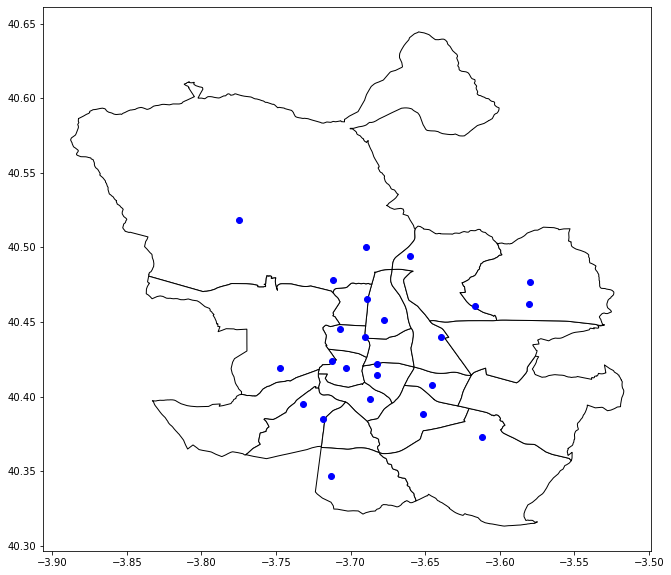

In [186]:
stations = gpd.GeoDataFrame(
    stations_bare, 
    geometry=gpd.points_from_xy(stations_bare.longitude, stations_bare.latitude))
base_map = madrid.plot(color='white', edgecolor='black')
stations.plot(ax=base_map, color='blue')

In [197]:
averages = []
for i in air_quality_carbon_monoxide.itertuples():
    #print(type(i))
    values = []
    for d in range(1, 31):
        value_key = f'D{d}'
        validation_key = f'V{d}'
        if d < 10:
            value_key = f'D0{d}'
            validation_key = f'V0{d}'
        if (getattr(i, validation_key) == 'V'):
            values.append(getattr(i, value_key))
    if len(values) == 0:
        averages.append(0)
    else:
        averages.append(np.mean(values))
air_quality_carbon_monoxide = air_quality_carbon_monoxide.assign(avg=averages)
avg_carbon_monoxide = air_quality_carbon_monoxide[['station', 'type', 'year', 'month', 'avg']]
avg_carbon_monoxide.head()

,station,type,year,month,avg
10,4,6,2020,1,0.510526
11,4,6,2020,2,0.285714
12,4,6,2020,3,0.000000
13,4,6,2020,4,0.100000
14,4,6,2020,5,0.104000


In [199]:
avg_carbon_monoxide.avg.max()

0.9115384615384614

In [198]:
with_stations = avg_carbon_monoxide.merge(stations_bare, left_on='station', right_on='code')
with_stations = with_stations.set_geometry('geometry')
# ax = madrid.plot(color='white', edgecolor='black')
# with_stations.plot(column='avg', ax=ax, cmap='YlOrBr')
class JSONEncoder(json.JSONEncoder):
    def default(self, obj):
        if hasattr(obj,'to_json'):
            return obj.to_json()
        return json.JSONEncoder.default(self, obj)
import json
print(json.dumps(with_stations, cls=JSONEncoder))

"{\"type\": \"FeatureCollection\", \"features\": [{\"id\": \"0\", \"type\": \"Feature\", \"properties\": {\"avg\": 0.5105263157894736, \"code\": 4, \"latitude\": 40.423882299999995, \"longitude\": -3.7122567, \"month\": 1, \"station\": 4, \"type\": 6, \"year\": 2020}, \"geometry\": {\"type\": \"Point\", \"coordinates\": [-3.7122567, 40.423882299999995]}}, {\"id\": \"1\", \"type\": \"Feature\", \"properties\": {\"avg\": 0.2857142857142857, \"code\": 4, \"latitude\": 40.423882299999995, \"longitude\": -3.7122567, \"month\": 2, \"station\": 4, \"type\": 6, \"year\": 2020}, \"geometry\": {\"type\": \"Point\", \"coordinates\": [-3.7122567, 40.423882299999995]}}, {\"id\": \"2\", \"type\": \"Feature\", \"properties\": {\"avg\": 0.0, \"code\": 4, \"latitude\": 40.423882299999995, \"longitude\": -3.7122567, \"month\": 3, \"station\": 4, \"type\": 6, \"year\": 2020}, \"geometry\": {\"type\": \"Point\", \"coordinates\": [-3.7122567, 40.423882299999995]}}, {\"id\": \"3\", \"type\": \"Feature\", \"

In [189]:
grouped = with_stations.groupby(['station'], as_index=False)
grouped.head()

,province,municipality,station,type,datapoint,year,month,D01,V01,D02,...,V29,D30,V30,D31,V31,avg,code,longitude,latitude,geometry
0,28,79,4,6,28079004_6_48,2020,1,0.7,V,0.7,...,N,0.1,N,0.1,V,0.510526,4,-3.712257,40.423882,POINT (-3.71226 40.42388)
1,28,79,4,6,28079004_6_48,2020,2,0.1,V,0.1,...,N,0.0,N,0.0,N,0.285714,4,-3.712257,40.423882,POINT (-3.71226 40.42388)
2,28,79,4,6,28079004_6_48,2020,3,0.0,N,0.1,...,N,0.0,N,0.0,N,0.000000,4,-3.712257,40.423882,POINT (-3.71226 40.42388)
3,28,79,4,6,28079004_6_48,2020,4,0.0,N,0.0,...,N,0.1,V,0.0,N,0.100000,4,-3.712257,40.423882,POINT (-3.71226 40.42388)
4,28,79,4,6,28079004_6_48,2020,5,0.1,V,0.1,...,V,0.1,V,0.1,V,0.104000,4,-3.712257,40.423882,POINT (-3.71226 40.42388)
10,28,79,8,6,28079008_6_48,2020,1,0.7,V,0.6,...,V,0.4,V,0.4,V,0.506667,8,-3.682316,40.421553,POINT (-3.68232 40.42155)
11,28,79,8,6,28079008_6_48,2020,2,0.3,V,0.3,...,V,0.0,N,0.0,N,0.462069,8,-3.682316,40.421553,POINT (-3.68232 40.42155)
12,28,79,8,6,28079008_6_48,2020,3,0.3,V,0.3,...,V,0.3,V,0.3,V,0.316667,8,-3.682316,40.421553,POINT (-3.68232 40.42155)
13,28,79,8,6,28079008_6_48,2020,4,0.3,V,0.3,...,V,0.2,V,0.0,N,0.226667,8,-3.682316,40.421553,POINT (-3.68232 40.42155)
14,28,79,8,6,28079008_6_48,2020,5,0.2,V,0.2,...,V,0.2,V,0.2,V,0.203333,8,-3.682316,40.421553,POINT (-3.68232 40.42155)


In [190]:
top = cm.get_cmap('Blues', 128)
bottom = cm.get_cmap('Reds', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
blueRed = ListedColormap(newcolors, name='BlueRed')

,station,NaN
0,4,"AxesSubplot(0.301226,0.125;0.422548x0.755)"
1,8,"AxesSubplot(0.301226,0.125;0.422548x0.755)"
2,16,"AxesSubplot(0.301226,0.125;0.422548x0.755)"
3,18,"AxesSubplot(0.301226,0.125;0.422548x0.755)"
4,24,"AxesSubplot(0.301226,0.125;0.422548x0.755)"
5,35,"AxesSubplot(0.301226,0.125;0.422548x0.755)"
6,36,"AxesSubplot(0.301226,0.125;0.422548x0.755)"
7,39,"AxesSubplot(0.301226,0.125;0.422548x0.755)"
8,56,"AxesSubplot(0.301226,0.125;0.422548x0.755)"
9,57,"AxesSubplot(0.301226,0.125;0.422548x0.755)"


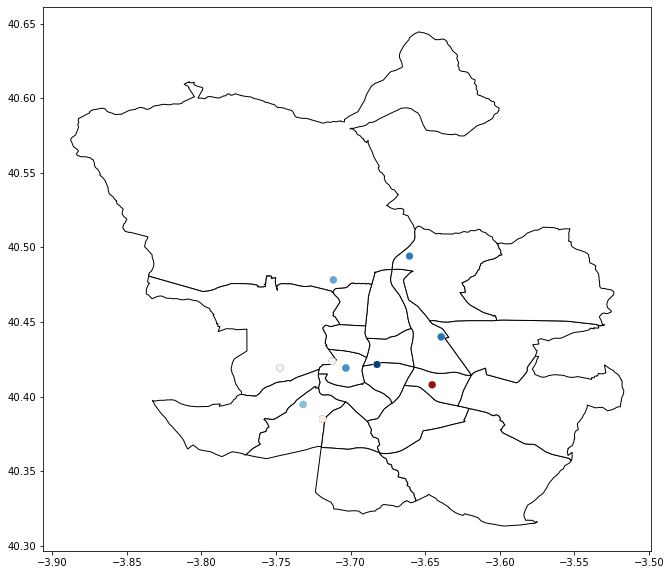

In [191]:
ax = madrid.plot(color='white', edgecolor='black')
grouped.plot(column='avg', ax=ax, cmap=blueRed)